# JusticeHunter или как понять, преступление ли это или нелепая случайность

Я часто вижу статьи о том, что теперь есть возможность определить, добьется ли человек потенциальных успехов в профессиональной или творческой сфере, грозит ли ему болезнь Альцгеймера или Паркинсона лет так через 50, как найти вторую половину, чтобы сразу и на всю жизнь, а также вообще, что за человек и какой ориентации. 

Но что касается исследований психологических заболеваний, понимания мотивации человека к тому или иному действию, в частности к преступлениям, уже информации не так много (возможна она недоступна или же действительно здесь сделать выводы сложнее). Но так как в тюрьмы к заключенным отправляют огромное количество консультантов для бесед с ними, а также для выяснения более подробной информации о них, я склонна предполагать, что здесь слишком много надо информации изучить, прежде чем приступить к ее интерпретации. 

И вот, прочитав книгу **Mind Hunter: Inside FBI’s Elite Serial Crime Unit** и посмотрев сериал **MindHunter** (рекомендую для любителей криминалистики, ведь его снимал сам ФИНЧЕР), я решила сделать свое исследование на эту тему.

Изначально я рассчитывала получить данные из университета Рэдфорда (это, пожалуй, один из самых крупных датасетов, где собрано множество информации о серийных убийцах за 30 лет проведения данного исследования), но не срослось (если у кого-то есть эти данные, то я буду безумно благодарна, если вы поделитесь ими со мной).

Вместо этого был найден датасет на kaggle, где собрана информация о преступлениях, тех, кто их совершил и пострадавших (жертвах). Здесь рассматриваются данные из отделений полиции нескольких штатов Америки о преступлениях, совершенных с 1980 - 2014. Целью проекта является понять, можно ли отличить преднамеренное преступление от причинения вреда по неосторожности, а также понять, какие из предикторов являются наиболее значимыми при определении типа преступления и достаточно ли их вообще.

In [2]:
# Отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid') #зададим базовое оформление
%pylab inline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.utils import shuffle

Populating the interactive namespace from numpy and matplotlib


## Описание данных

Возьмем из данных только те столбцы, которые будут важны для дальнейшего исследования
(также в данных содержится информация о полиции, сроке расследования, а также о человеке, проводившем допрос)

In [4]:
df = pd.read_csv('dataframe.csv', usecols=['Year', 'Month', 'Victim Sex', 'Victim Age', 'Victim Race', 'Perpetrator Sex',
                                          'Perpetrator Age', 'Perpetrator Race', 'Relationship',
                                          'Weapon', 'Victim Count', 'Crime Type'])

Посмотрим как выглядят данные

In [5]:
df.head()

,Year,Month,Victim Sex,Victim Age,Victim Race,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon,Victim Count,Crime Type
0,1980,January,Male,14,Native American/Alaska Native,Male,15,Native American/Alaska Native,Acquaintance,Blunt Object,0,1
1,1980,March,Male,43,White,Male,42,White,Acquaintance,Strangulation,0,1
2,1980,March,Female,30,Native American/Alaska Native,Unknown,0,Unknown,Unknown,Unknown,0,1
3,1980,April,Male,43,White,Male,42,White,Acquaintance,Strangulation,0,1
4,1980,April,Female,30,Native American/Alaska Native,Unknown,0,Unknown,Unknown,Unknown,0,1


- Year - год совершения преступления
- Month - месяц совершения преступления
- Victim Sex - пол жертвы
- Victim Age - возраст жертвы
- Victim Race - раса жертвы
- Perpetrator Sex - пол исполнителя
- Perpetrator Age - возраст исполнителя
- Perpetrator Race - раса исполнителя
- Relationship - Родственные связи между исполнителем и жертвой
- Weapon - оружие
- Victim Count - количество жертв
- Crime Type - целевой признак, убийство (преднамеренное нанесение вреда) или приченение вреда по неосторожности

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258342 entries, 0 to 1258341
Data columns (total 12 columns):
Year                1258342 non-null int64
Month               1258342 non-null object
Victim Sex          1258342 non-null object
Victim Age          1258342 non-null int64
Victim Race         1258342 non-null object
Perpetrator Sex     1258342 non-null object
Perpetrator Age     1258342 non-null int64
Perpetrator Race    1258342 non-null object
Relationship        1258342 non-null object
Weapon              1258342 non-null object
Victim Count        1258342 non-null int64
Crime Type          1258342 non-null int64
dtypes: int64(5), object(7)
memory usage: 115.2+ MB


Как видно из данных есть несколько категориальных признаков, поэтому воспользуемся Label Encoding

In [7]:
categorical_columns = df.columns[df.dtypes == 'object']
numerical_columns = ['Year', 'Victim Age', 'Perpetrator Age', 'Victim Count']

In [8]:
label_encoder = LabelEncoder()
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,Year,Month,Victim Sex,Victim Age,Victim Race,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon,Victim Count,Crime Type
0,1980,4,1,14,2,1,15,2,0,0,0,1
1,1980,7,1,43,4,1,42,4,0,13,0,1
2,1980,7,0,30,2,2,0,3,26,15,0,1
3,1980,0,1,43,4,1,42,4,0,13,0,1
4,1980,0,0,30,2,2,0,3,26,15,0,1


Посмотрим на корреляцию между признаками

In [9]:
corr_features = df.drop('Crime Type', axis=1).corr()

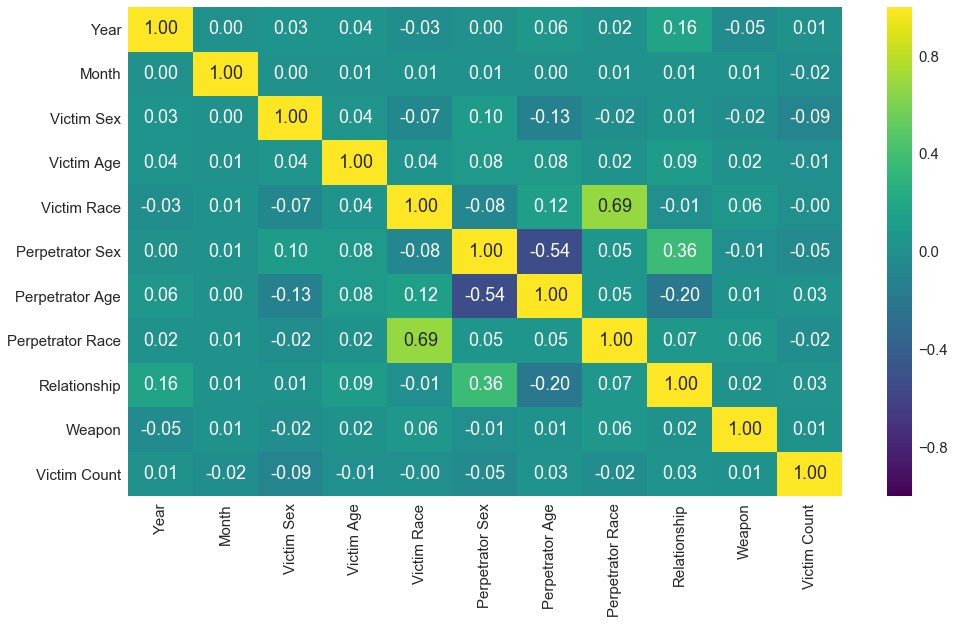

In [10]:
sns.set(font_scale=1.5)
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(corr_features, cmap='viridis', annot=True, ax=ax, fmt='.2f')

Видим, что достаточно высокая корреляция между расой жертвы и преступника

Посмотрим на соотношение типа совершаемых убийств между женщинами и мужчинами, где
- 0 - причинение вреда по неосторожности
- 1 - убийство или преднамеренное нанесение ущерба

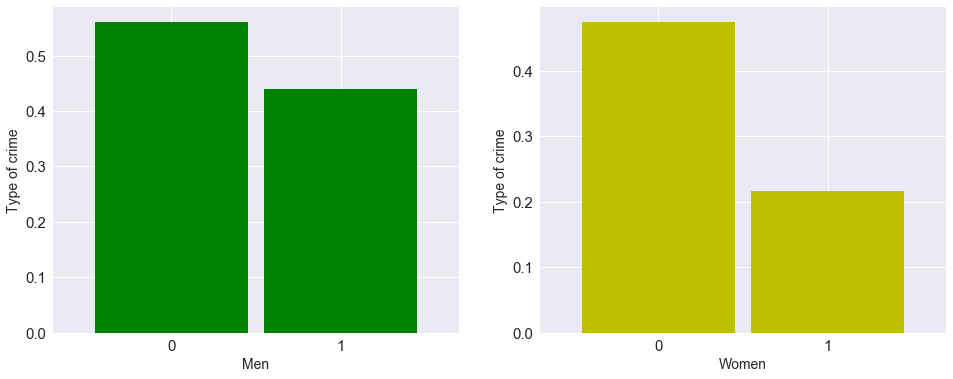

In [11]:
plt.figure(figsize(16,6))
plt.subplot(121)
stat_red = df[df['Perpetrator Sex'] == 1].groupby('Crime Type')['Crime Type'].agg(lambda x: float(len(x))/df[df['Perpetrator Sex'] == 1].shape[0])
stat_red.plot(kind='bar', color='g', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Type of crime', fontsize=14)
plt.xlabel('Men', fontsize=14)

plt.subplot(122)
stat_white = df[df['Perpetrator Sex'] == 0].groupby('Crime Type')['Crime Type'].agg(lambda x: float(len(x))/df[df['Perpetrator Sex'] == 2].shape[0])
stat_white.plot(color='y', kind='bar', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Type of crime', fontsize=14)
plt.xlabel('Women', fontsize=14)

В данных есть те преступления, где виновный неизвестен и их возраст указан как 0. Я уберу из выборки такие данные

In [12]:
df = df[df['Perpetrator Age'] != 0]

Дополнительные данные можно получить только с помощью дополнительных сведений о преступнике или жертве и характере преступления, поэтому дальнейшие действия будут производиться на тех данных, которые есть

## Перейдем к обучению модели

### Random Forest

Сначала попробуем Random Forest, так как он не требует детальную предварительную настройку, а также есть возможность выявить степень предиктора, что нам и необходимо согласно поставленной цели

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

Так как отдельно тестовой выборки нет, разделим все данные на тестовые и валидационные в соотношении 70:30 и обучим **Random Forest** с параметрами `n_estimators=100, max_depth=15, max_features=5`

In [11]:
sns.set(style = 'ticks', color_codes = True)

df = shuffle(df)
class_label = df.pop('Crime Type')
X_train, X_valid, y_train, y_valid = train_test_split(df, class_label, test_size = .7)

             precision    recall  f1-score   support

          0       0.92      0.92      0.92    439991
          1       0.92      0.92      0.92    440849

avg / total       0.92      0.92      0.92    880840



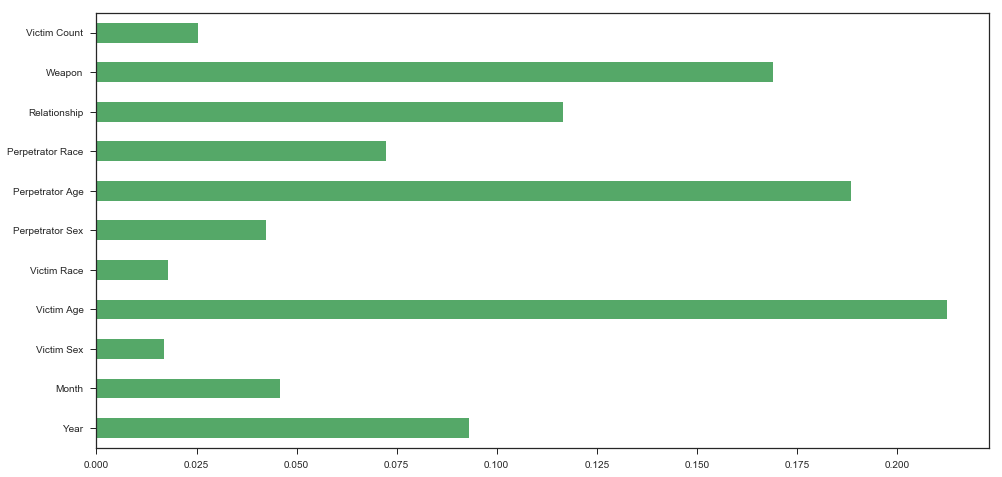

CPU times: user 2min 55s, sys: 2.88 s, total: 2min 58s
Wall time: 51 s


In [12]:
%%time
model_rfc = RandomForestClassifier(n_estimators=100, max_depth=15, max_features=5, random_state=17, n_jobs=-1).\
                               fit(X_train, y_train)
print(classification_report(y_valid, model_rfc.predict(X_valid)))
plt.figure(figsize(16,8))
pd.Series(model_rfc.feature_importances_, index=X_valid.columns).plot(kind='barh', color='g')
plt.show()

Получается достаточно высокий уровень точности, но практически нет информации о значимости предикторов, так как все признаки находятся на одинаково небольшом уровне

### CatBoost

Попробуем другие алгоритмы, которые способны также показать степень важности предикторов. Следующим будет CatBoost. Используем его без преднасроенных гиперпараметров

In [13]:
from catboost import CatBoostClassifier

In [14]:
model_cbc = CatBoostClassifier().fit(X_train, y_train)

print(classification_report(y_valid, model_cbc.predict(X_valid)))
pd.Series(model_cbc.get_feature_importance(X_valid, y_valid), index = X_valid.columns)

             precision    recall  f1-score   support

          0       0.84      0.83      0.84    439991
          1       0.83      0.84      0.84    440849

avg / total       0.84      0.84      0.84    880840



Year                 9.515051
Month                1.484272
Victim Sex           1.686989
Victim Age          12.607389
Victim Race          1.412973
Perpetrator Sex      2.585089
Perpetrator Age      9.880449
Perpetrator Race     4.668861
Relationship        18.750084
Weapon              29.622655
Victim Count         7.786190
dtype: float64

Из полученных результатов видно, что больший вес отдается признаку `Weapon`, хотя в `Random Forest` признак с наибольшим весом - `Victim Age`

### XGBoost

Для сравнения проделаем аналогичную операцию с **XGBoost**

In [15]:
import xgboost as xgb

/Users/elenadevyataykina/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


             precision    recall  f1-score   support

          0       0.82      0.81      0.82    439991
          1       0.81      0.82      0.82    440849

avg / total       0.82      0.82      0.82    880840



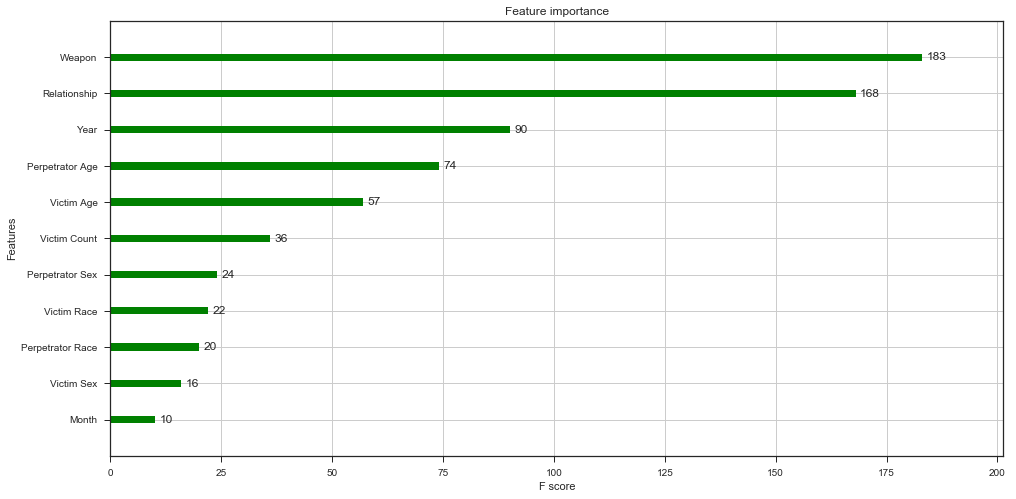

In [16]:
model_xgb = xgb.XGBClassifier().fit(X_train, y_train)

print(classification_report(y_valid, model_xgb.predict(X_valid)))
importance = model_xgb.booster().get_score(importance_type = 'gain')
pd.Series(list(importance.values()), index = importance.keys())

xgb.plot_importance(model_xgb, color='green')
plt.show()

Здесь также видно, что самым значимым признаком является `Weapon`, после которого почти сразу же следует `Relationship`, что выглядит вполне логично



### KNeighborsClassifier

В задачах анализа поведенческих факторов часто используется алгоритм ближайших соседей. Это связано с тем, что расстояние (например, евклидова метрика) между двумя векторами похожих людей будет близким. Логично предположить, что люди одной группы набирают похожее количество баллов, возможно, формируя несколько кластеров. 

Данный алгоритм не позволяет показывать степень важности предикторов. Но в небольших наборах данных обычно вручную удаляются признаки, а ддалее смотрят на качество обучения модели без него.

Алгоритм ближайших соседей весьма чувствителен к разной природе данных (и к выбросам), следовательно, аналогично алгоритмам на основе нейронных сетей или методу опорных векторов требует предварительную нормализацию

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)

In [18]:
model_knn = KNeighborsClassifier(n_neighbors=7, n_jobs=-1).fit(X_train_scaled, y_train)
print(classification_report(y_valid, model_knn.predict(X_valid_scaled)))

             precision    recall  f1-score   support

          0       0.91      1.00      0.95    439991
          1       1.00      0.90      0.94    440849

avg / total       0.95      0.95      0.95    880840



### Tensorflow

Ради эксперимента посмотрим на результат алгоритма на основе нейронных сетей (указано 3000 шагов для ускорения расчетов)

In [29]:
%%time
import tensorflow as tf

def get_train_inputs():
    xr = tf.constant(X_train_scaled)
    yr = tf.constant(y_train)
    return xr, yr

def get_test_inputs():
    xr = tf.constant(X_valid_scaled)
    yr = tf.constant(y_valid)
    return xr, yr

model_tf = tf.contrib.learn.DNNClassifier(feature_columns = [tf.contrib.layers.real_valued_column('', dimension = 4)],
                                          hidden_units = [10, 20, 10], n_classes = 2, model_dir = 'tmp_dir_tensorflow').\
                            fit(input_fn = get_train_inputs, steps=3000)

predictions = list(model_tf.predict(input_fn = get_test_inputs))
print(classification_report(y_valid, predictions))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13c782f10>, '_model_dir': 'tmp_dir_tensorflow', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_evaluation_master': '', '_master': ''}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tmp_dir_tensorflow/model.ckpt.
INFO:tensorflow:loss = 0.681445, step = 1
INFO:tensorflow:global_step/sec: 2.64503
INFO:tensorflow:loss = 0.597883, step = 101 (37.808 sec)
INFO:tensorflow:global_step/sec: 2.78658
INFO:tensorflow:loss =

## Выводы

Теперь можно перейти к выводам: 
    
в результате данного исследования было выявлено, что по представленному вектору можно с достаточно высокой степенью точности назвать правильный класс наблюдения, но все же недостаточной, если речь идет о том, чтобы быть посаженным на несколько лет. Поэтому в здачах подобного рода надо большое внимание уделить сбору данных, а также корректной интерпретации.

Были рассмотрены алгоритмы

- RandomForestClassifier
- CatBoostClassifier
- xgboost
- KNeighborsClassifier
- tensorflow

Что касается признаков, то удалось выделить те, которые имеют наибольший вес из имеющихся, но все же для такого исследования признаков недостаточно. 
Если бы была возможность, то я бы еще точно добавила информацию об образовании, о семье подозреваемого, а также ответы на специально подобранные вопросы в зависимости от характера преступления. 

---
**Если у вас есть вопросы, критика или вы хотите поделиться своими мыслями на этот счет, то в slack вы можете меня найти как @elenadevyataykina**